# IoT GNN Demo

## Env Setup
To use this notebook, a conda environment has to be created beforehand. Commands to create the environment and install the minimal packages:
```bash
conda create -n iot_env python=3.11
conda activate iot_env
conda install pytorch
conda install pandas
conda install scikit-learn
conda install matplotlib
conda install pytorch::torchdata
conda install conda-forge::dgl
```  
Then, the conda environment has to be exported.  
```bash
conda install ipykernel
python -m ipykernel install --user --name iot_env --display-name "Python (iot_env)"
```  
Select the iot_env kernel to run the ipynb.

## Imports

In [1]:
from configuration import *

from models import e_graphsage, fnn_model
from data import IoTDataset
from train import ModelTrainer
import tester

/home/rowleyra/anaconda3/envs/iot_env/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
/home/rowleyra/anaconda3/envs/iot_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Randomized IP Addresses and Ports

### Load Data
This assumes there is a "data" folder under the root of the IoT_GNN repo.  
Datasets can be found at: https://drive.google.com/drive/folders/14t41P09gXTsCqPx3YFN1Pruwb2eZQrkT?usp=share_link

In [2]:
multiclass = True
randomized_ip_train_data = IoTDataset(version=1, multiclass=multiclass)
randomized_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val')
randomized_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test')

### Sanity Check
Running forward pass on the untrained E_GraphSAGE model.  
Only for initial debugging purposes.

In [ ]:
# Local var in order to not modify the graph permanently.
#graph = train_data[0].local_var()
#temp = e_graphsage.E_GraphSAGE(numLayers=2, num_edge_attr=8, dim_node_embed=128, num_classes=5)
#temp.forward(graph)

### Model Initialization

In [3]:
model_egs = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=64,
                                num_edge_attr=randomized_ip_train_data.num_features,
                                num_classes=len(randomized_ip_train_data.classes)
                                )
model_fnn = fnn_model.TestFNN(num_hidden_layers=3,
                              hidden_layer_widths=[64, 64, 128],  # Should be approximately comparable to EGS
                              num_edge_attr=randomized_ip_train_data.num_features,
                              num_classes=len(randomized_ip_train_data.classes),
                            )

In [4]:
# 175 epochs sufficient for EGS to get plateau of validation risk.
egs_training_config = {
        'num_epochs': 175,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
# 205 epochs for the FNN
fnn_training_config = {
        'num_epochs': 205,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

### Training

In [5]:
# Instantiate Trainer
egs_trainer = ModelTrainer(egs_training_config, randomized_ip_train_data, randomized_ip_val_data)
fnn_trainer = ModelTrainer(fnn_training_config, randomized_ip_train_data, randomized_ip_val_data)

In [6]:
# Train the GNN
egs_trainer.train_model(model_egs, False)

Training E_GraphSAGE_K2: 100%|██████████| 175/175 [02:16<00:00,  1.28epoch/s, train loss=0.7207, validation loss=0.8188, learning rate=1.00e-03, F1 score=0.76750]


In [ ]:
# Train the FCNN
fnn_trainer.train_model(model_fnn, False)

### Testing

TODO: Clean up the tester

In [42]:
# If modify tester
import importlib
importlib.reload(tester)

<module 'tester' from '/home/rowleyra/Documents/ECE1508/IoT_GNN/tester.py'>

In [43]:
tester_inst = tester.ModelTester(randomized_ip_test_data, False)

===== Test Report =====
== Benign ==
Precision: 0.204429
Recall:    0.719336
F1-score:  0.318378

== DDoS ==
Precision: 0.392294
Recall:    0.980735
F1-score:  0.560420

== DoS ==
Precision: 0.000000
Recall:    0.000000
F1-score:  0.000000

== Reconnaissance ==
Precision: 0.990061
Recall:    0.821164
F1-score:  0.897738

== Theft ==
Precision: 0.042407
Recall:    0.418848
F1-score:  0.077016

== weighted avg ==
Precision: 0.818512
Recall:    0.754874
F1-score:  0.764770

= Global Metrics =
Accuracy:           0.754874
Balanced Accuracy:  0.588017

Confusion Matrix:
[[ 1994    62     0   519   197]
 [   19 11149     0    19   181]
 [   16 11130     0    19   202]
 [ 7725  6076     0 77297  3033]
 [    0     3     0   219   160]]


Report and confusion matrix recorded in:  /home/rowleyra/Documents/ECE1508/IoT_GNN/checkpoints/NF-BoT-IoT-v1-randomized-multiclassE_GraphSAGE_K2


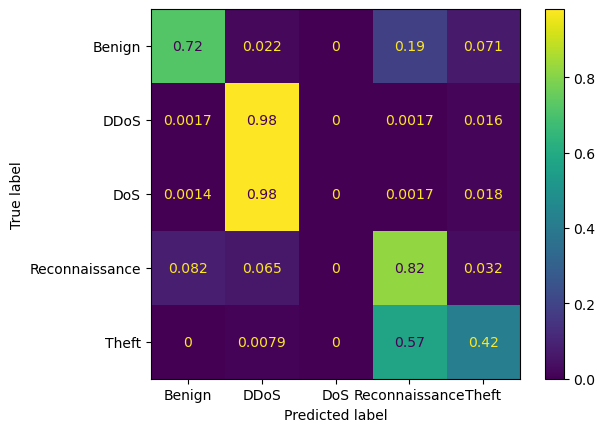

In [44]:
tester_inst.test_model(model_egs)

In [ ]:
tester_inst.test_model(model_fnn)

## Non-Randomized IP Addresses and Ports

### Load Data

In [ ]:
multiclass = True
orig_ip_train_data = IoTDataset(version=1, multiclass=multiclass, randomize_source_ip=False)
orig_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val', randomize_source_ip=False)
orig_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test', randomize_source_ip=False)

### Model Initialization

In [ ]:
model_egs_orig = e_graphsage.E_GraphSAGE(numLayers=2,
                                    dim_node_embed=64,
                                    num_edge_attr=orig_ip_train_data.num_features,
                                    num_classes=len(orig_ip_train_data.classes)
                                    )
model_fnn_orig = fnn_model.TestFNN(num_hidden_layers=3,
                              hidden_layer_widths=[64, 64, 128],  # Should be approximately comparable to EGS
                              num_edge_attr=orig_ip_train_data.num_features,
                              num_classes=len(orig_ip_train_data.classes),
                             )

### Training

In [ ]:
# 175 epochs sufficient for EGS to get plateau of validation risk.
egs_orig_training_config = {
        'num_epochs': 175,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
# 205 epochs for the FNN
fnn_orig_training_config = {
        'num_epochs': 205,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

In [ ]:
# Instantiate Trainer
egs_orig_trainer = ModelTrainer(egs_training_config, orig_ip_train_data, orig_ip_val_data)
fnn_orig_trainer = ModelTrainer(fnn_training_config, orig_ip_train_data, orig_ip_val_data)

In [ ]:
# Train the GNN
egs_orig_trainer.train_model(model_egs, False)

In [ ]:
# Train the FCNN
fnn_orig_trainer.train_model(model_fnn, False)